<a href="https://colab.research.google.com/github/IFuentesSR/JoH_drought/blob/main/SPEI_from_Log_Logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SPEI standardisation from log-logistic distribution

This notebook is associated with the implementation of the SPEI estimation as presented in Beguería et al. (2010).





In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=0LTm1oj4X2eFtLMs3wrHd8QWcoxOUnx1YvnePVAF4uY&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7BunaNz1342oXAkEw381kYZmxwxaY8gji1SDONHs3XDv-zd2SXJ0o

Successfully saved authorization token.


In [ ]:
# Folium setup.
import folium
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

print(folium.__version__)

0.8.3


### Functions for log-logistic distribution and conversion to standardised index

In [ ]:
def to_collection(b):
    date = ee.String(b).slice(6)
    img = image.select([b]).setMulti({'system:time_start':ee.Date(date).millis(), 'date':date})
    return ee.Image(img).rename('difference')


def iter(col, scale):
    col = ee.ImageCollection(col)
    def inner(img):
        date = ee.Date(img.get('system:time_start'))
        condition = ee.Algorithms.If(col.filterDate(date.advance(ee.Number(scale).multiply(-1), 'month'), date).size().eq(0),
                                     ee.Image().setMulti({'drop':1}),
                                     collection.filterDate(date.advance(ee.Number(scale).multiply(-1), 'month'), date).sum().set({'drop':0, 'month':date.get('month')})
            )
        return ee.Image(condition).set('system:time_start', date.millis())
    return inner


def set_month(img):
    img = ee.Image(img)
    return img.set('month', ee.Date(img.get('system:time_start')).get('month'))


def LMoments(collection, order, month):
    def inner(i):
        return ee.Image(ee.Number(1).subtract((ee.Number(i).subtract(0.35)).divide(length))).pow(order)
    collection = ee.ImageCollection(collection)
    length = collection.size()
    array = collection.toArray()
    sorted = array.arraySort()
    n = sorted.arrayLength(0)
    indices = ee.List.sequence(1, length)
    ixs = ee.ImageCollection.fromImages(indices.map(inner))
    ixs = ixs.toArray()
    multiplication = ixs.multiply(sorted)
    reduction = multiplication.arrayReduce('sum', [0]).divide(n)
    label = ee.String('w').cat(ee.Number(order).format()).cat('_').cat(ee.Number(month).toInt().format())
    return reduction.arrayProject([0]).arrayFlatten([[label]])


def get_params(month_collection, month):
    w0 = LMoments(month_collection, 0, month)
    w1 = LMoments(month_collection, 1, month)
    w2 = LMoments(month_collection, 2, month)
    ws = ee.Image.cat([w0, w1, w2])
    beta = w1.expression('(2*w1 - w0)/(6*w1 - w0 - 6*w2)', 
                         {'w0': w0, 'w1': w1, 'w2': w2})
    gamma1 = (ee.Image(1).add(ee.Image(1).divide(beta))).gamma()
    gamma2 = (ee.Image(1).subtract(ee.Image(1).divide(beta))).gamma()
    alpha = (w0.subtract(w1.multiply(2))).multiply(beta).divide(gamma1.multiply(gamma2))
    gamma = w0.subtract(alpha.multiply(gamma1).multiply(gamma2))
    return ee.Image.cat([alpha, beta, gamma]).rename(['alpha', 'beta', 'gamma'])


def spei(params, img):
    props = img.propertyNames()
    Fx = img.expression('(1 + (a/(i - g))**b)**(-1)',
                        {'a': params.select('alpha'), 'b': params.select('beta'), 'g':params.select('gamma'), 'i':img})
    p = ee.Image(1).subtract(Fx)
    W = p.log().multiply(-2).sqrt().where(p.gt(0.5), ee.Image(1).subtract(p).log().multiply(-2).sqrt())
    fract = W.expression('(C0 + C1*W + C2*W**2)/(1 + d1*W + d2*W**2 + d3*W**3)',
                            {'W':W, 'C0':2.515517, 'C1':0.802853, 'C2':0.010328,
                            'd1':1.432788, 'd2':0.189269, 'd3':0.001308})
    spei = W.subtract(fract).where(p.gt(0.5), fract.subtract(W))
    return spei.copyProperties(img, props)


def spei_col(params):
    params = ee.Image(params)
    def inner(img):
        img = ee.Image(img)
        props = img.propertyNames()
        Fx = img.expression('(1 + (a/(i - g))**b)**(-1)',
                            {'a': params.select('alpha'), 'b': params.select('beta'), 'g':params.select('gamma'), 'i':img})
        p = ee.Image(1).subtract(Fx)
        W = p.log().multiply(-2).sqrt().where(p.gt(0.5), ee.Image(1).subtract(p).log().multiply(-2).sqrt())
        fract = W.expression('(C0 + C1*W + C2*W**2)/(1 + d1*W + d2*W**2 + d3*W**3)',
                                {'W':W, 'C0':2.515517, 'C1':0.802853, 'C2':0.010328,
                                'd1':1.432788, 'd2':0.189269, 'd3':0.001308})
        spei = W.subtract(fract).where(p.gt(0.5), fract.subtract(W))
        return spei.copyProperties(img, props)
    return inner



### Bringing some variables

Since SPEI uses a series containing the difference between rainfall and ETr, a variable stored and shared needs to be called. This corresponds to a mutiband image containing a band for each date. 

Additionally we set a scale for the analysis and choose a geometry for evaluation.

In [ ]:
image = ee.Image("users/ignisfausto/rainMinusETo")
geometry = ee.Geometry.Point([-59.59282246847122, -8.75223189304376])
scale = 1
bands = image.bandNames()
print(bands.getInfo())

['PP-ET_1982-01-01', 'PP-ET_1982-02-01', 'PP-ET_1982-03-01', 'PP-ET_1982-04-01', 'PP-ET_1982-05-01', 'PP-ET_1982-06-01', 'PP-ET_1982-07-01', 'PP-ET_1982-08-01', 'PP-ET_1982-09-01', 'PP-ET_1982-10-01', 'PP-ET_1982-11-01', 'PP-ET_1982-12-01', 'PP-ET_1983-01-01', 'PP-ET_1983-02-01', 'PP-ET_1983-03-01', 'PP-ET_1983-04-01', 'PP-ET_1983-05-01', 'PP-ET_1983-06-01', 'PP-ET_1983-07-01', 'PP-ET_1983-08-01', 'PP-ET_1983-09-01', 'PP-ET_1983-10-01', 'PP-ET_1983-11-01', 'PP-ET_1983-12-01', 'PP-ET_1984-01-01', 'PP-ET_1984-02-01', 'PP-ET_1984-03-01', 'PP-ET_1984-04-01', 'PP-ET_1984-05-01', 'PP-ET_1984-06-01', 'PP-ET_1984-07-01', 'PP-ET_1984-08-01', 'PP-ET_1984-09-01', 'PP-ET_1984-10-01', 'PP-ET_1984-11-01', 'PP-ET_1984-12-01', 'PP-ET_1985-01-01', 'PP-ET_1985-02-01', 'PP-ET_1985-03-01', 'PP-ET_1985-04-01', 'PP-ET_1985-05-01', 'PP-ET_1985-06-01', 'PP-ET_1985-07-01', 'PP-ET_1985-08-01', 'PP-ET_1985-09-01', 'PP-ET_1985-10-01', 'PP-ET_1985-11-01', 'PP-ET_1985-12-01', 'PP-ET_1986-01-01', 'PP-ET_1986-02-01',

We transform the multiband image into an Image Collection, and sum the collection based on the scale used

In [ ]:
collection = bands.map(to_collection)
collection = ee.ImageCollection.fromImages(collection).sort('system:time_start')
collection1 = collection.map(iter(collection, scale)).map(set_month)
collection1 = collection1.filter(ee.Filter.eq('drop', 0))


Then we select a single date to get a raster and calculate its SPEI.

In [ ]:
test = collection1.filterDate('2019-07-01', '2020-01-01').first()
coll2 = collection1.filter(ee.Filter.eq('month', test.get('month')))
params = get_params(coll2, test.get('month'))
spei_test = spei(params, test)


### Mapping SPEI image

In [ ]:
mapidCon = ee.Image(spei_test).getMapId({'min': -3, 'max': 3, 'palette': 'FF0000, FFFFFF, 0000FF', 'opacity':0.4})
centroid = geometry.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='SPEI',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### Generating SPEI collection
Now let's define a function to apply this standardisation to all images in the collection by mapping it through a set of months and years defined.

In [ ]:
def get_collection(col):
    def inner0(m):
        years = ee.List.sequence(1982, 2019)
        def inner(y):
            date0 = ee.Date.fromYMD(y, m, 1)
            return col.filterDate(date0, date0.advance(1, 'month')).first()
        coll = ee.ImageCollection.fromImages(years.map(inner))
        params = get_params(coll, m)
        speis = coll.map(spei_col(params))
        return ee.ImageCollection(speis).toList(50)
    return inner0


 def get_sample(img):
    date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    spei_value = img.reduceRegion('first', geometry, 25000).values().get(0)
    return ee.Feature(None, {'date':date, 'spei':spei_value})


months = ee.List.sequence(1, 12)
spei_collection = months.map(get_collection(collection1))
spei_collection = ee.ImageCollection.fromImages(spei_collection.flatten()).sort('system:time_start')

### Mapping a singe image from the generated collection

In [ ]:
mapidCon = ee.Image(spei_collection.filterDate('2019-07-01', '2020-01-01').first()).getMapId({'min': -3, 'max': 3, 'palette': 'FF0000, FFFFFF, 0000FF', 'opacity':0.4})
centroid = geometry.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='SPEI',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### Plotting estimated SPEI through time using our geometry

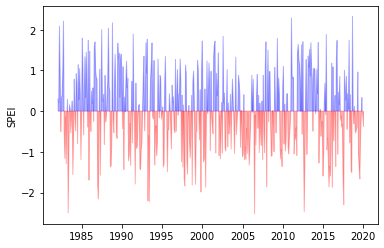

In [ ]:
series = spei_collection.map(get_sample).getInfo()

ixs = [n['properties']['spei'] for n in series['features']]
time = [pd.to_datetime(n['properties']['date'], format='%Y-%m-%d') for n in series['features']]
df = pd.DataFrame(data={'spei':ixs, 'date':time})
d = np.zeros(len(ixs))

fig, axs = plt.subplots()
axs.fill_between(time, d, ixs, where=df['spei']>=d, interpolate=True, color='blue', alpha=0.3, label='SVI')
axs.fill_between(time, d, ixs, where=df['spei']<=d, interpolate=True, color='red', alpha=0.3)
axs.set_ylabel('SPEI')
fig.show()

### Creating another collection using a scale of 3

In [ ]:
scale = 3
collection3 = collection.map(iter(collection, scale)).map(set_month)
collection3 = collection3.filter(ee.Filter.eq('drop', 0))

spei_collection3 = months.map(get_collection(collection3))
spei_collection3 = ee.ImageCollection.fromImages(spei_collection3.flatten()).sort('system:time_start')
series3 = spei_collection3.map(get_sample).getInfo()

### Plotting both series to compare

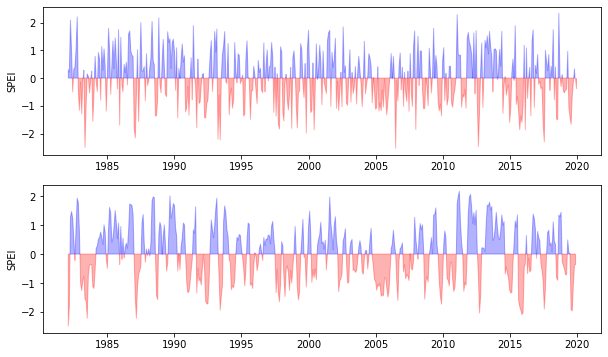

In [ ]:
ixs3 = [n['properties']['spei'] for n in series3['features']]
time3 = [pd.to_datetime(n['properties']['date'], format='%Y-%m-%d') for n in series3['features']]
df3 = pd.DataFrame(data={'spei':ixs3, 'date':time3})
d3 = np.zeros(len(ixs3))

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 6))
ax1.fill_between(time, d, ixs, where=df['spei']>=d, interpolate=True, color='blue', alpha=0.3, label='SVI')
ax1.fill_between(time, d, ixs, where=df['spei']<=d, interpolate=True, color='red', alpha=0.3)
ax1.set_ylabel('SPEI')

ax2.fill_between(time3, d3, ixs3, where=df3['spei']>=d3, interpolate=True, color='blue', alpha=0.3, label='SVI')
ax2.fill_between(time3, d3, ixs3, where=df3['spei']<=d3, interpolate=True, color='red', alpha=0.3)
ax2.set_ylabel('SPEI')
fig.show()